# CoRaLS.jl Monte Carlo detection rates

In [1]:
# Import and compile modules - slow the first time you run on a fresh kernel
# using Pkg; pkg"activate ~/projects/CoRaLS.jl/"  # <- sometimes needed in multithreded mode
using CoRaLS
using PyPlot
using Unitful: km, sr, EeV, MHz, m, μV, cm, ustrip

Compute acceptance, specifying parameters with kw arguments. Plot results with `plot_acceptance()` which returns a matplotlib fig and ax object that can be used to customie the plot.

┌ Info: Calculating acceptance using 100000 trials across 8 bins with up to 99 retries
└ @ CoRaLS /home/cjtu/projects/CoRaLS.jl/src/acceptance.jl:67
Simulating... 100%|██████████████████████████████████████| Time: 0:00:04


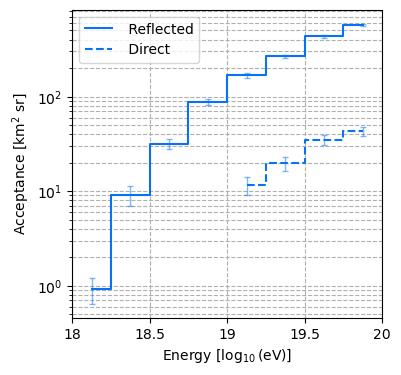

In [2]:
A = acceptance(100000, 8, region=create_region("psr:south"), spacecraft=CircularOrbit(50.0km); 
               ice_depth=6.0m, min_energy=1.0EeV, max_energy=100.0EeV, ν_min=100MHz, ν_max=1000MHz, dν=30MHz,
               simple_area=true, trigger=magnitude_trigger(50μV/m), min_count=10, max_tries=100)

# Plot and exclude results with fewer than min_count detections (noisy) 
fig, ax = plot_acceptance(A; min_count=10)
fig

To plot the rate, we use `plot_differential_spectrum`.

In [19]:
fig, ax = plot_differential_spectrum(A, 1yr)
fig

UndefVarError: UndefVarError: `psr_fraction` not defined in `CoRaLS`
Suggestion: check for spelling errors or missing imports.

We can also break down events by their outcomes (reason for rejection).

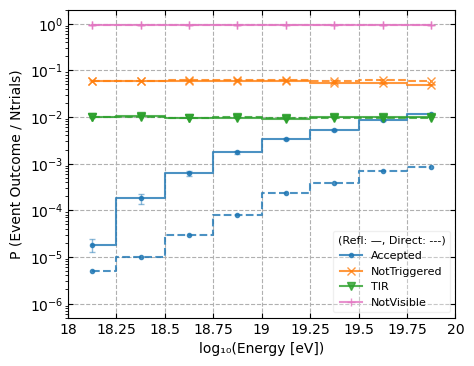

In [3]:
fig, ax = plot_event_outcomes(A)
fig

### Region options for `create_region(config::String)`

| Option                                      | Prefix             | Parameters<sup>†</sup>                | Example config string         |
|----------------------------------------------|--------------------|---------------------------------------|------------------------------|
| Entire Moon                                 | `whole_moon`       | -                                  | `"whole_moon"`                 |
| South Polar region (5.57% PSR cover)        | `psr:south`        | -                                  | `"psr:south"`                  |
| North Pole PSR region (4.46% PSR cover)     | `psr:north`        | -                                  | `"psr:north"`                  |
| PSR North and South                         | `psr:all`          | -                                  | `"psr:all"`                    |
| Quadrangle (lat/lon bounds)                 | `quad:`            | `min_lat`, `max_lat`,<br>`min_lon`, `max_lon`,<br>`aoi_frac` (optional) | `"quad:-60,60,-90,90"`     |
| Spherical cap (diam in degrees)             | `cap:`             | `center_lat`, `center_lon`, `dlat`,<br>`aoi_frac` (optional)        | `"cap:90,0,30"`             |
| Circular region (radius in km)              | `circle:`          | `center_lat`, `center_lon`,<br>`radius_km`,<br>`aoi_frac` (optional)   | `"circle:10,20,50"`        |
| Polar region (pole=`north` or `south`)      | `polar:`           | `pole`, `max_lat`,<br>`aoi_frac` (optional)                          | `"polar:south,-80"`         |

<sup>†</sup> `aoi_frac` is optional and denotes the area of interest is a uniformly distributed subset of the specified region (float in 0-1). E.g., `psr:south` is equivalent to `polar:south,-80,0.0557`.

**Notes:**
- For `polar:`, the first parameter is the pole (`north` or `south`), the second is `max_lat` (degrees from pole).
- Both `circle` and `cap` amount to spherical caps, but `circle:` supplies a `radius_km` in kilometers (e.g. a crater), while spherical cap gives angular diameter `dlat` in degrees (e.g. a polar cap or nearside / farside cap).


┌ Info: Calculating acceptance using 10000 trials across 8 bins with up to 99 retries
└ @ CoRaLS /home/cjtu/projects/CoRaLS.jl/src/acceptance.jl:67
Simulating... 100%|██████████████████████████████████████| Time: 0:00:02
┌ Info: Calculating acceptance using 10000 trials across 8 bins with up to 99 retries
└ @ CoRaLS /home/cjtu/projects/CoRaLS.jl/src/acceptance.jl:67
Simulating... 100%|██████████████████████████████████████| Time: 0:00:03


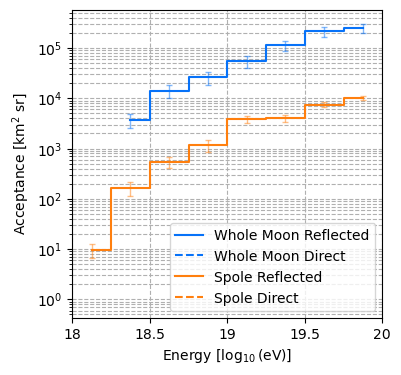

In [4]:
whole_moon = create_region("whole_moon")
spole = create_region("polar:south,-80")
# keyword params can be passed as a Dict, eg:
kws = Dict(:ice_depth=>6.0m, :min_energy=>1.0EeV, :max_energy=>100.0EeV, 
           :ν_min=>100MHz, :ν_max=>1000MHz, :dν=>30MHz, :trigger=>magnitude_trigger(50μV/m),
           :spacecraft=>CircularOrbit(50.0km), :simple_area=>true, 
           :min_count=>10, :max_tries=>100)

Amoon = acceptance(10000, 8; region=whole_moon, kws...)
Aspole = acceptance(10000, 8; region=spole, kws...)

fig, ax = plot_acceptance(Amoon; min_count=10, name="Whole Moon")
fig, ax = plot_acceptance(Aspole; min_count=10, ax=ax, name="Spole", colorrefl="tab:orange")
fig  # Show figure in notebook

### Spacecraft options for `create_spacecraft(config::String)`

| Option                        | Prefix         | Parameters<sup>‡</sup>                                   | Example config string         |
|-------------------------------|---------------|----------------------------------------------------------|------------------------------|
| Fixed platform                | `fixed:`      | `lat`, `lon`, `alt_km`                                   | `"fixed:-80,0,50"`           |
| Circular orbit                | `orbit:`      | `alt_km`                                                 | `"orbit:50"`                 |
| Elliptical orbit              | `elliptical:` | `periapse_km`, `apoapse_km`, `inclination_deg`           | `"elliptical:40,100,90"`     |
| Sampled orbit from CSV file   | `file:`       | `filename`                                               | `"file:lro_orbit_1yr_2010.csv"` |

<sup>‡</sup> All distances are in kilometers, lat and lon are in degrees.
- `fixed:` is a stationary platform at some `alt_km` above (`lat`, `lon`).  
- For `elliptical:`, `periapse_km` and `apoapse_km` are pericenter and apocenter altitudes above lunar surface in km, `inclination_deg` is the orbital inclination in degrees.  
- `file:`, is a CSV of orbit positions with columns: time, longitude, latitude, altitude.


Simulating... 100%|██████████████████████████████████████| Time: 0:00:08


1 km#51


Simulating... 100%|██████████████████████████████████████| Time: 0:00:05


10 km#51


Simulating... 100%|██████████████████████████████████████| Time: 0:00:17


100 km#51


Simulating... 100%|██████████████████████████████████████| Time: 0:01:31


1000 km#51


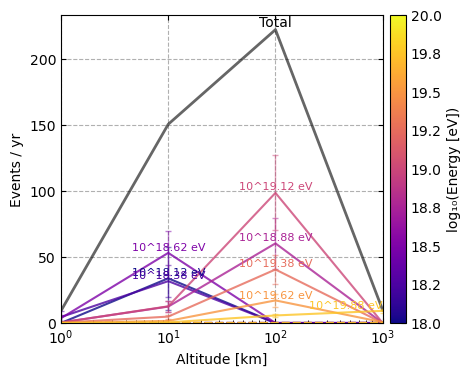

In [ ]:
import Logging; Logging.disable_logging(Logging.Info)  # Silence the repetitive logs

# Save acceptance results in a simple loop
kws = Dict(:ice_depth=>6.0m, :min_energy=>1.0EeV, :max_energy=>100.0EeV, 
           :ν_min=>300MHz, :ν_max=>1000MHz, :dν=>30MHz, :simple_area=>true, 
           :min_count=>10, :max_tries=>100)

altitudes = [1, 10, 100, 1000]km
As = []
for altitude in altitudes
    sc = CircularOrbit(altitude)
    trigger = LPDA(Nant=4, Ntrig=4, θ0=-90.0, altitude=altitude)
    Aspole = acceptance(10000, 8; region=spole, spacecraft=sc, trigger=trigger, kws...)
    println(altitude, trigger)
    push!(As, Aspole)
end

# Plot the rates in events/yr vs altitude
fig, ax = plot_rate_experiment(As, altitudes; xlabel="Altitude [km]")
fig


Info from the resulting `Acceptance` struct

- input params: `ntrials`, `region`, `spacecraft`, `energies` [EeV]
- Accptances (direct, reflected): `dAΩ`, `rAΩ`  [km^2 sr]
- Raw acceptance counts: `dcount`, `rcount`
- Failure counts: `dfailed`, `rfailed`, `failtypes`

The `plot_acceptance` function is just showing dAΩ, rAΩ vs energy with some formatting. Accessing those directly we can make a simple plot:

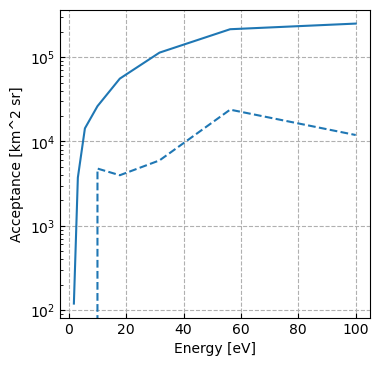

In [14]:
# Note: to plot with pyplot, syntax is same as python but units need to be removed
#  use ustrip(value) or ustrip.(vector) before plotting quantities with units
A = Amoon
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot(ustrip.(A.energies[2:end]), ustrip.(A.rAΩ), color="tab:blue")
plot(ustrip.(A.energies[2:end]), ustrip.(A.dAΩ), color="tab:blue", linestyle="--")
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Acceptance [km^2 sr]")
ax.set_yscale("log")
gcf()

# Running the old version of the model (circa 2023 model)

- Only configured for the poles (PSR area and geometric factors hardcoded)
- Can't input custom orbit (circular orbit only at pole)
- All TIR events rejected

In [7]:
using CoRaLS
using Unitful: km, sr, EeV, MHz, m, μV, cm, ustrip

Aold = old_acceptance(10000, 20; 
            altitude=40km, 
            ice_depth=6.0m,
            min_energy=1.0EeV,
            ν_max=1000MHz,
            dν=30MHz,
            trigger=magnitude_trigger(67μV/m),
            save_events=false)

Simulating... 100%|██████████████████████████████████████| Time: 0:00:01


CoRaLS.OldAcceptance(10000, 40 km, Unitful.Quantity{Float64, 𝐋^2, Unitful.FreeUnits{(km^2, sr), 𝐋^2, nothing}}[11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr, 11612.622144668607 km^2 sr], Unitful.Quantity{Float64, 𝐋^2 𝐌 𝐓^-2, Unitful.FreeUnits{(EeV,), 𝐋^2 𝐌 𝐓^-2, nothing}}[1.0 EeV, 1.376916367710489 EeV, 1.8958986836690466 EeV, 2.6104939290646807 EeV, 3.5944318187380233 EeV, 4.949232003839765 EeV, 6.814678553683553 EeV, 9.383242441252527 EeV, 12.919940099556333 EeV, 17.789676992918192 EeV  …  33.72742519377113 

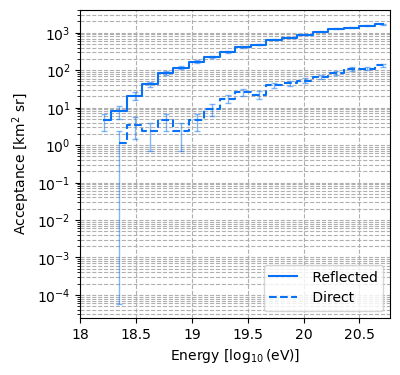

In [8]:
plot_acceptance(Aold; min_count=1)
gcf()

## Comparing New and Old MCMC to analytical (geometric) acceptance


In [24]:
using CoRaLS
using Unitful: km, sr, EeV, MHz, m, μV, cm, ustrip
using Statistics
using PyPlot
import Logging
Logging.disable_logging(Logging.Info)

# Altitudes and analytical redults (reversed only to frontload longer computations)
altitudes = reverse([1, 10, 50, 100, 500, 1000, 1e5]km)
alex = reverse(pi*[10910.1, 1e5, 530552., 1.03223*10^6, 4.23844*10^6, 6.92853*10^6, 1.86423*10^7])

# Params
ntrials = 10000  # Baseline test: 100_000
nbins = 8  # Baseline test: 20
kws = Dict(:ice_depth=>6.0m,:min_energy=>1.0EeV,:max_energy=>100.0EeV,:ν_min=>150MHz,:ν_max=>1000MHz,:dν=>30MHz)
region = create_region("polar:south,-80,0.0557")  # create_region("psr:all")

results_moon = []
results_psr = []
results_old = []
for altitude in altitudes
    # Note: we create spacecraft explicitly here to pass altitude rather than using create_spacecraft("orbit:X")
    sc = CircularOrbit(altitude)  
    trigger = LPDA(Nant=4, Ntrig=4, θ0=-90.0, altitude=altitude, skyfrac=0)

    # New (whole moon)
    A = acceptance(ntrials, 4, region=WholeMoonRegion(), spacecraft=sc; trigger=trigger_all(), kws...)
    push!(results_moon, A)

    # New (PSR only - do more samples)
    AP = acceptance(ntrials, nbins, region=region, spacecraft=sc; simple_area=true, trigger=trigger, min_count=10, max_tries=10, kws...)
    push!(results_psr, AP)

    # Old (2023 version - ntrials are run for each bin so divide by nbins for consistent # of events)
    AO = old_acceptance(ntrials÷nbins, nbins; altitude=altitude, save_events=false, trigger=trigger, min_count=10, max_tries=10, kws...)
    push!(results_old, AO)
end

Simulating... 100%|██████████████████████████████████████| Time: 0:00:20
Simulating... 100%|██████████████████████████████████████| Time: 0:00:09
Simulating... 100%|██████████████████████████████████████| Time: 0:00:06
Simulating... 100%|██████████████████████████████████████| Time: 0:00:02
Simulating... 100%|██████████████████████████████████████| Time: 0:00:01


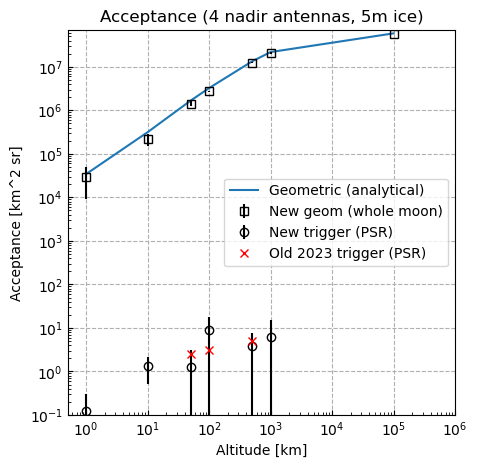

In [25]:
alts = ustrip.(altitudes)
accmoon = ustrip.([mean(r.dAΩ) for r in results_moon])
errmoon = ustrip.([std(r.dAΩ) for r in results_moon])
accpsr = ustrip.([mean(r.dAΩ) for r in results_psr])
errpsr = ustrip.([std(r.dAΩ) for r in results_psr])
oldacc = ustrip.([mean(r.dAΩ) for r in results_old])
olderr = ustrip.([std(r.dAΩ) for r in results_old])

# Plot
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["axes.axisbelow"] = true
rcParams["axes.grid"] = true
rcParams["grid.linestyle"] = "dashed"
rcParams["xtick.direction"] = "in"
rcParams["ytick.direction"] = "in"

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.set_title("Acceptance (4 nadir antennas, 5m ice)")
axs.loglog(alts, alex, label="Geometric (analytical)")
axs.errorbar(alts, accmoon, errmoon, fmt="ks", markerfacecolor="none", label="New geom (whole moon)" )

# Note: old version computes rates for PSRs at both poles so we multiply the south rate by 2 here. Remove factor when running with region "psr:all"
axs.errorbar(alts, 2*accpsr, errpsr, fmt="ko", markerfacecolor="none", label="New trigger (PSR)")
axs.errorbar(alts, oldacc, fmt="rx", label="Old 2023 trigger (PSR)")
axs.set_ylabel("Acceptance [km^2 sr]")
axs.legend(loc="best")
axs.set_xlabel("Altitude [km]")
axs.set_ylim(1e-1, 7e7)
axs.set_xlim(5e-1, 1e6)
gcf()  # Show plot in notebook